In [1]:
# Disable warnings

import warnings
warnings.filterwarnings("ignore")

# Import libraries 

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Library dealing with NA values

from sklearn.impute import SimpleImputer

# acquire
from env import host, user, password
import wrangle_mall


from sklearn.model_selection import train_test_split
import sklearn.preprocessing

### 1.  Acquire data from mall_customers.customers in mysql database.

In [2]:
df = wrangle_mall.get_mall_data()
df.head(3)

,gender,age,annual_income,spending_score
customer_id,,,,
1,Male,19,15,39
2,Male,21,15,81
3,Female,20,16,6


### 2.  Summarize data (include distributions and descriptive statistics).

In [3]:
df.shape

(200, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB


In [5]:
df.describe()

,age,annual_income,spending_score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


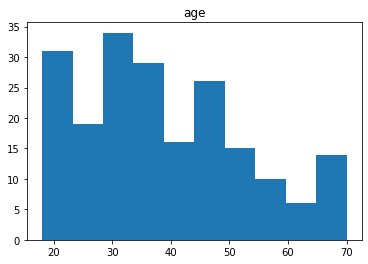

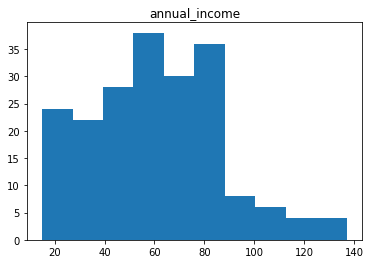

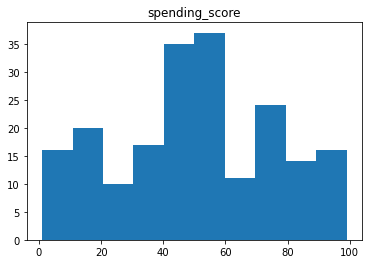

In [6]:
# distributions

num_cols = ['age', 'annual_income', 'spending_score']

for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()

<AxesSubplot:title={'center':'spending_score distribution'}>

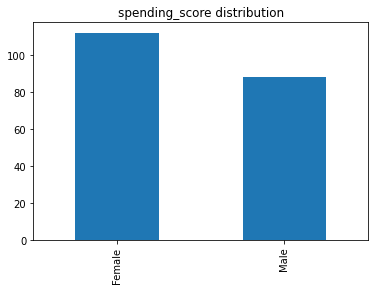

In [7]:
# distributions

df['gender'].value_counts().plot(kind='bar', title = f"{col} distribution")

### 3. Detect outliers using IQR.

In [8]:
df.shape

(200, 4)

In [9]:
def detect_outliers(df, k, col_list):
    ''' get upper and lower bound for list of columns in a dataframe 
        if desired return that dataframe with the outliers removed
    '''
    
    outliers = pd.DataFrame()
    
    for col in col_list:

        q1, q2, q3 = df[f'{col}'].quantile([.25, .5, .75])  # get quartiles
        
        iqr = q3 - q1   # calculate interquartile range
        
        upper_bound = q3 + k * iqr   # get upper bound
        lower_bound = q1 - k * iqr   # get lower bound
        
        # print each col and upper and lower bound for each column
        print(f"{col}: Median = {q2} lower_bound = {lower_bound} upper_bound = {upper_bound}")

        # return dataframe of outliers
        outliers = outliers.append(df[(df[f'{col}'] < lower_bound) | (df[f'{col}'] > upper_bound)])
            
    return outliers

In [10]:
outliers = detect_outliers(df, 1.5,['age', 'annual_income', 'spending_score'])

age: Median = 36.0 lower_bound = -1.625 upper_bound = 79.375
annual_income: Median = 61.5 lower_bound = -13.25 upper_bound = 132.75
spending_score: Median = 50.0 lower_bound = -22.625 upper_bound = 130.375


In [11]:
outliers

,gender,age,annual_income,spending_score
customer_id,,,,
199,Male,32,137,18
200,Male,30,137,83


### 4.  Split data (train, validate, and test split).

In [12]:
def train_validate_test_split(df):
    '''split df into train, validate, test'''
    
    train, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train, test_size=.3, random_state=123)
    
    return train, validate, test

In [13]:
train, validate, test = train_validate_test_split(df)

In [14]:
print(train.shape, validate.shape, test.shape)

(112, 4) (48, 4) (40, 4)


### 5.  Encode categorical columns using a one hot encoder (pd.get_dummies).

In [15]:
def encoding(df, cols, drop_first=True):
    '''
    Take in df and list of columns
    add encoded columns derived from columns in list to the df
    '''
    for col in cols:

        dummies = pd.get_dummies(df[f'{col}'], drop_first=drop_first) # get dummy columns

        df = pd.concat([df, dummies], axis=1) # add dummy columns to df
        
    return df

In [16]:
train = encoding(train, ['gender'], drop_first=True)
validate = encoding(validate, ['gender'], drop_first=True)
test = encoding(test, ['gender'], drop_first=True)

In [17]:
print(train.shape, validate.shape, test.shape)

(112, 5) (48, 5) (40, 5)


In [18]:
train.head()

,gender,age,annual_income,spending_score,Male
customer_id,,,,,
124,Male,39,69,91,1
77,Female,45,54,53,0
172,Male,28,87,75,1
11,Male,67,19,14,1
36,Female,21,33,81,0


### 6.  Handles missing values.

In [19]:
# number of missing values

df.isna().sum()

gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [20]:
## no missing values to handle

### 7. Scaling

In [21]:
def min_max_scaling(train, validate, test, num_cols):
    '''
    Add scaled versions of a list of columns to train, validate, and test
    '''
    
    # reset index for merge 
    train = train.reset_index(drop=True)
    validate = validate.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    scaler = sklearn.preprocessing.MinMaxScaler() # create scaler object

    scaler.fit(train[num_cols]) # fit the object 

    # transform to get scaled columns
    train_scaled = pd.DataFrame(scaler.transform(train[num_cols]), columns = train[num_cols].columns + "_scaled")
    validate_scaled = pd.DataFrame(scaler.transform(validate[num_cols]), columns = validate[num_cols].columns + "_scaled")
    test_scaled = pd.DataFrame(scaler.transform(test[num_cols]), columns = test[num_cols].columns + "_scaled")
    
    # add scaled columns to dataframes
    train = train.merge(train_scaled, left_index=True, right_index=True)
    validate = validate.merge(validate_scaled, left_index=True, right_index=True)
    test = test.merge(train_scaled, left_index=True, right_index=True)
    
    return train_scaled, validate_scaled, test_scaled

In [22]:
train_scaled, validate_scaled, test_scaled = min_max_scaling(train, validate, test, ['age', 'annual_income', 'spending_score'])

In [23]:
print(train_scaled.shape, validate_scaled.shape, test_scaled.shape)

(112, 3) (48, 3) (40, 3)


In [24]:
train_scaled.head()

,age_scaled,annual_income_scaled,spending_score_scaled
0,0.403846,0.442623,0.957447
1,0.519231,0.319672,0.553191
2,0.192308,0.590164,0.787234
3,0.942308,0.032787,0.138298
4,0.057692,0.147541,0.851064


In [25]:
validate_scaled.head()

,age_scaled,annual_income_scaled,spending_score_scaled
0,0.019231,0.270492,0.617021
1,0.653846,0.598361,0.127660
2,0.269231,0.270492,0.489362
3,0.596154,0.409836,0.617021
4,0.115385,0.040984,0.808511


In [26]:
test_scaled.head()

,age_scaled,annual_income_scaled,spending_score_scaled
0,0.596154,0.221311,0.542553
1,0.423077,0.459016,1.000000
2,0.230769,0.155738,0.765957
3,0.307692,0.516393,0.946809
4,0.326923,0.065574,1.031915


### wrangle_mall.py - Functions to do the above

In [27]:
def wrangle_mall_data():
    col_list = ['age', 'annual_income', 'spending_score']
    # let's acquire our data...
    df = get_mall_data()
    # summarize the data
    print(summarize(df))
    # add upper outlier columns
    df = add_upper_outlier_columns(df)
    # add lower outlier columns
    df = add_lower_outlier_columns(df)
    # describe the outliers
    print(outlier_describe(df))
    # drop outliers
    df = remove_outliers(df, 1.5, col_list)
    # split the data
    train, validate, test = split_data(df)
    # drop missing values from train
    train = train.dropna()
    # scale the data
    train_scaled, \
    validate_scaled, \
    test_scaled = min_max_scaling(train, validate, test, num_cols)
    print(f'          train shape: {train.shape}')
    print(f'       validate shape: {validate.shape}')
    print(f'           test shape: {test.shape}')
    print(f'   train_scaled shape: {train_scaled.shape}')
    print(f'validate_scaled shape: {validate_scaled.shape}')
    print(f'    test_scaled shape: {test_scaled.shape}')

----------------------------------------------------
DataFrame Head
             gender  age  annual_income  spending_score
customer_id                                            
1              Male   19             15              39
2              Male   21             15              81
3            Female   20             16               6
----------------------------------------------------
DataFrame Info
<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          200 non-null    object
 1   age             200 non-null    int64 
 2   annual_income   200 non-null    int64 
 3   spending_score  200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 7.8+ KB
None
----------------------------------------------------
DataFrame Description
              age  annual_income  spending_score
count  200.000000     200.000000     

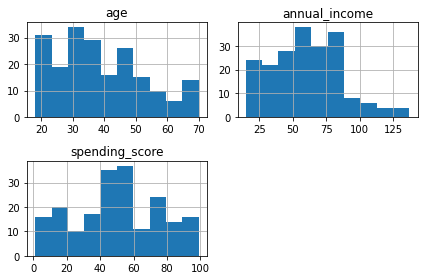

None
age_upper_outliers : 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age_upper_outliers, dtype: float64
annual_income_upper_outliers : 
count    2.00
mean     4.25
std      0.00
min      4.25
25%      4.25
50%      4.25
75%      4.25
max      4.25
Name: annual_income_upper_outliers, dtype: float64
spending_score_upper_outliers : 
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: spending_score_upper_outliers, dtype: float64
age_lower_outliers : 
count    200.000000
mean      40.475000
std       13.969007
min       19.625000
25%       30.375000
50%       37.625000
75%       50.625000
max       71.625000
Name: age_lower_outliers, dtype: float64
annual_income_lower_outliers : 
count    200.000000
mean      73.810000
std       26.264721
min       28.250000
25%       54.750000
50%       74.750000
75%       91.250000
max      150.250000
Name: annual_income_lower_out

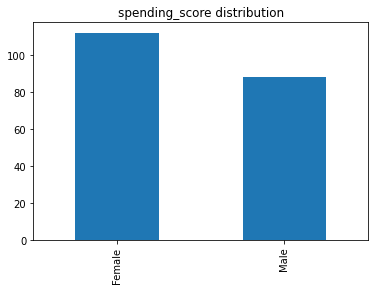

In [28]:
wrangle_mall.wrangle_mall_data()